In [1]:
import pandas as pd

df_interactions = pd.read_csv(
    '../../docs/coolbet/data/prod/interactions.csv',
    usecols=['user_id', 'match_id', 'created_at'],
    parse_dates=['created_at']
)
df_interactions.head()

,user_id,match_id,created_at
0,26380,2276004,2022-10-24 00:00:00.625400+00:00
1,62988,2298985,2022-10-24 00:00:00.937569+00:00
2,62988,2298984,2022-10-24 00:00:00.937569+00:00
3,62988,2297370,2022-10-24 00:00:00.937569+00:00
4,62988,2297369,2022-10-24 00:00:00.937569+00:00


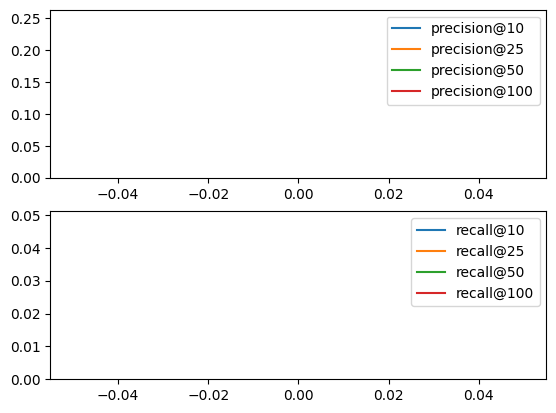

4671406it [09:58, 7809.12it/s]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

factors = 100
reg_coef = 1.0
learning_rate = 0.005
eval_interval = 100000000

A = {}
B = {}


def hit_rate(gt, recommendations):
    result = {}
    
    for k in [10, 25, 50, 100]:
        gt_item_ids = gt.iloc[:k]['match_id'].unique()
        tp = len([x for x in recommendations[:k] if x['id'] in gt_item_ids])
        result.update({ 
            f'precision@{k}': tp / len(recommendations[:k]),
            f'recall@{k}': tp / len(gt_item_ids)
        })
    return result


def evaluate(A, B, test_set):
    results = []
    for user_id in test_set['user_id'].unique():
        if user_id not in A:
            continue
        gt = test_set[test_set['user_id'] == user_id]
        pred = [{'id': item_id, 'score': A[user_id] * B[item_id]} for item_id in B.keys()]
        results.append(hit_rate(gt, pred))
    results = pd.DataFrame(results)
    
    return results.mean()
        
precisions = []
recalls = []

for index, row in tqdm(df_interactions.iterrows()):
    if row.user_id not in A:
        A[row.user_id] = np.random.normal(loc=0, scale=0.1, size=factors)
    if row.match_id not in B:
        B[row.match_id] = np.random.normal(loc=0, scale=0.1, size=factors)
    
    err = 1 - A[row.user_id] * B[row.match_id].T
    A[row.user_id] = A[row.user_id] + learning_rate * (err * B[row.match_id] - reg_coef * A[row.user_id])
    B[row.match_id] = B[row.match_id] + learning_rate * (err * A[row.user_id] - reg_coef * B[row.match_id])
    
    if index % eval_interval == 1:
        metrics = evaluate(A, B, df_interactions.iloc[index:])
        
        precisions.append(metrics[['precision@10', 'precision@25', 'precision@50', 'precision@100']])
        recalls.append(metrics[['recall@10', 'recall@25', 'recall@50', 'recall@100']])

        display.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2)
        
        ax1.plot(range(len(precisions)), precisions)
        ax1.set_ylim(ymin=0)
        ax1.legend(precisions[-1].keys())
        
        ax2.plot(range(len(recalls)), recalls)
        ax2.set_ylim(ymin=0)
        ax2.legend(recalls[-1].keys())
        
        plt.show()

In [26]:
df_A = pd.DataFrame({ 'user_id': A.keys(), 'features': A.values() })
df_B = pd.DataFrame({ 'item_id': B.keys(), 'features': B.values() })
df_B.head()

,item_id,features
0,2276004,"[-0.0010523405859781164, -0.004974576674571425..."
1,2298985,"[0.0024970364672179295, 0.0030266715489704657,..."
2,2298984,"[-0.0002987383739329924, -0.005433240028878901..."
3,2297370,"[0.001266481367015598, 0.0015787549263839085, ..."
4,2297369,"[-0.005686888820454337, -0.0023494075293557255..."


In [27]:
idx = int(len(df_interactions) * 0.8)
test_df = df_interactions.iloc[idx:]
test_df

,user_id,match_id,created_at
3737124,62026,2303534,2022-10-30 12:43:20.186637+00:00
3737125,62026,2319241,2022-10-30 12:43:20.186637+00:00
3737126,62026,2319240,2022-10-30 12:43:20.186637+00:00
3737127,62026,2303618,2022-10-30 12:43:20.186637+00:00
3737128,62026,2187870,2022-10-30 12:43:20.186637+00:00
...,...,...,...
4671401,26261,2306522,2022-11-01 15:48:47.340245+00:00
4671402,26261,2305520,2022-11-01 15:48:47.340245+00:00
4671403,26261,2305521,2022-11-01 15:48:47.340245+00:00
4671404,26261,2305518,2022-11-01 15:48:47.340245+00:00


In [30]:
df_A = df_A[df_A.index.isin(test_df['user_id'])]
df_A

,user_id,features
2,68725,"[-0.07826679607250314, -0.028671063662532248, ..."
3,63815,"[0.0042104467348631465, 0.004154790985765059, ..."
5,2534,"[-0.12228963020119508, -0.05458166964783145, 0..."
6,63822,"[0.05172664331010451, 0.01765231444281441, -0...."
8,30521,"[0.004928601347621386, -0.0016569041303510462,..."
...,...,...
69999,39324,"[0.07447637742814074, 0.06791546196694126, 0.1..."
70003,66616,"[-0.05834804183687119, 0.10132373192948528, -0..."
70007,32842,"[-0.09467676159799478, -0.16988961734684804, 0..."
70009,26072,"[-0.027787328418280587, -0.06555945922983637, ..."


In [39]:
def recommend(user_features):
    df_B['score'] = df_B.apply(lambda x: x['features'].dot(user_features), axis=1)
    return df_B.sort_values('score', ascending=False).iloc[:25]['item_id']

df_A.apply(lambda x: pd.Series({ 'user_id': x['user_id'], 'recommendations': recommend(x['features']) }), axis=1)

KeyboardInterrupt: 

In [11]:
def hit_rate(gt, recommendations):
    gt_item_ids = gt['match_id'].unique()
    return len([x for x in recommendations if x['id'] in gt_item_ids]) / len(recommendations)


idx = int(len(df_interactions) * 0.8)
test_df = df_interactions.iloc[idx:]



print("Evaluating test set...")
metrics = []

user_ids = test_df['user_id'].unique()
for user_id in tqdm(user_ids):
    y_hat = [{'id': item_id, 'score': np.dot(A[user_id], B[item_id])} for item_id in B.keys()]
    y_hat = sorted(y_hat, reverse=True, key=lambda x: x['score'])[:25]

    y = test_df[test_df['user_id'] == user_id]
    if len(y_hat) > 0:
        metrics.append(hit_rate(y, y_hat))

metrics = np.array(metrics)
print(metrics.sum() / len(metrics))


Evaluating test set...


100%|██████████| 36258/36258 [10:57<00:00, 55.12it/s]

0.0004004633460201887


In [6]:
df_interactions['user_id'] = df_interactions['user_id'].astype('category')
df_interactions['match_id'] = df_interactions['match_id'].astype('category')
df_interactions.head()

,user_id,match_id,created_at
0,26380,2276004,2022-10-24 00:00:00.625400+00:00
1,62988,2298985,2022-10-24 00:00:00.937569+00:00
2,62988,2298984,2022-10-24 00:00:00.937569+00:00
3,62988,2297370,2022-10-24 00:00:00.937569+00:00
4,62988,2297369,2022-10-24 00:00:00.937569+00:00


In [12]:
user_item_pairs = list(zip(df_interactions['user_id'].cat.codes, df_interactions['match_id'].cat.codes))
user_item_pairs

[(26379, 307),
 (62987, 381),
 (62987, 380),
 (62987, 376),
 (62987, 375),
 (62987, 382),
 (62987, 384),
 (68724, 203),
 (63814, 1245),
 (19911, 682),
 (19911, 931),
 (19911, 251),
 (19911, 336),
 (19911, 799),
 (19911, 992),
 (19911, 932),
 (19911, 9),
 (19911, 1676),
 (2533, 9),
 (63821, 1676),
 (13613, 1272),
 (30520, 1676),
 (30520, 927),
 (30520, 1245),
 (30520, 1244),
 (30520, 1168),
 (19667, 1676),
 (49006, 1676),
 (55738, 1168),
 (45548, 1676),
 (34626, 372),
 (34626, 381),
 (34626, 382),
 (34626, 386),
 (34626, 455),
 (34626, 448),
 (34626, 456),
 (34626, 438),
 (68127, 980),
 (13791, 1676),
 (13791, 1246),
 (13791, 984),
 (44998, 980),
 (7558, 1239),
 (16866, 251),
 (16866, 1676),
 (16866, 980),
 (16866, 1169),
 (63814, 927),
 (56018, 1273),
 (2829, 337),
 (67855, 1245),
 (67855, 984),
 (67855, 983),
 (18503, 203),
 (51205, 544),
 (51205, 359),
 (51205, 380),
 (51205, 382),
 (51205, 552),
 (51205, 548),
 (51205, 545),
 (51205, 563),
 (51205, 559),
 (26416, 984),
 (43149, 1583

In [13]:
from scipy.sparse import csr_matrix

csr_matrix(user_item_pairs)

<4671406x2 sparse matrix of type '<class 'numpy.int64'>'
	with 9342653 stored elements in Compressed Sparse Row format>